In [1]:
import numpy as np 
import pandas as pd
import copy

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from sklearn.decomposition import PCA
from imblearn.under_sampling import RandomUnderSampler as under_sam

from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
from sklearn.metrics import matthews_corrcoef, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier

# Main implementation

In [2]:
# loading the train set
df_train = pd.read_csv('EvalResources/KDDTrain+.txt', sep=",", header=None, skipinitialspace = True)
df_train = df_train[df_train.columns[:-1]]  # tags column
titles = pd.read_csv('EvalResources/Field Names.csv', header=None, skipinitialspace = True)
label = pd.Series(['label'], index=[41])
titles = pd.concat([titles[0], label])
df_train.columns = titles.to_list()
df_train = df_train.drop(['num_outbound_cmds'],axis=1)
df_train_original = df_train

# df_train_original.to_csv('KB Process/NSL-KDD Original Datasets/KDDTrain+_with_labels.txt', index=False)

#df_train_original

In [3]:
# load test set
df_test = pd.read_csv('EvalResources/KDDTest+.txt', sep=",", header=None, skipinitialspace = True)
df_test_ = df_test.sort_index(axis=1)
df_test = df_test[df_test.columns[:-1]]
df_test.columns = titles.to_list()
df_test = df_test.drop(['num_outbound_cmds'],axis=1)
df_test_original = df_test

# df_test_original.to_csv('KB Process/NSL-KDD Original Datasets/KDDTest+.txt', index=False)

#df_test_original

### Execution Parameters

In [4]:
EXPORT_MODELS = 0
EXPORT_DATASETS = 0
EXPORT_PCA = 0
EXPORT_ENCODERS = 0

pd.options.display.max_columns = None

In [5]:
# list of single attacks 
dos_attacks = ['back', 'land', 'neptune', 'pod', 'smurf', 'teardrop', 'worm', 'apache2', 'mailbomb', 'processtable', 'udpstorm']
probe_attacks = ['ipsweep', 'mscan', 'nmap', 'portsweep', 'saint', 'satan']
r2l_attacks = ['guess_passwd', 'ftp_write', 'imap', 'phf', 'multihop', 'warezmaster',
                'snmpguess', 'spy', 'warezclient', 'httptunnel', 'named', 'sendmail', 'snmpgetattack', 'xlock', 'xsnoop']
u2r_attacks = ['buffer_overflow', 'loadmodule', 'perl', 'ps', 'rootkit', 'sqlattack', 'xterm'] 

# list of attack classes split according to detection layer
dos_probe_list = ['back', 'land', 'neptune', 'pod', 'smurf', 'teardrop', 'ipsweep', 'nmap', 'portsweep', 'satan']
dos_probe_test = ['apache2', 'mailbomb', 'processtable', 'udpstorm', 'mscan', 'saint']
u2r_r2l_list = ['guess_passwd', 'ftp_write', 'imap', 'phf', 'multihop', 'warezmaster',
                'snmpguess', 'spy', 'warezclient', 'buffer_overflow', 'loadmodule', 'rootkit', 'perl']
u2r_r2l_test = ['httptunnel', 'named', 'sendmail', 'snmpgetattack', 'xlock', 'xsnoop', 'ps', 'xterm', 'sqlattack']
normal_list = ['normal']
categorical_features = ['protocol_type', 'service', 'flag']

In [6]:
# load the features obtained with ICFS for both layer 1 and layer 2
with open('KBProcess/AWS Downloads/MinimalFeatures/NSL_features_l1.txt', 'r') as f:
    common_features_l1 = f.read().split(',')

with open('KBProcess/AWS Downloads/MinimalFeatures/NSL_features_l2.txt', 'r') as f:
    common_features_l2 = f.read().split(',')

In [7]:
df_train_and_validate = copy.deepcopy(df_train_original)
df_test = copy.deepcopy(df_test_original)

In [8]:
# save all the targets for the dataset

y_test_l1 = [1 if x in (dos_attacks+probe_attacks) else 0 for x in df_test['label']]
y_test_l2 = [1 if x in (u2r_attacks+r2l_attacks) else 0 for x in df_test['label']]

if EXPORT_DATASETS:
    np.save("EvalResources/AdditionalSets/l1_full_test_targets.npy", y_test_l1)
    np.save("EvalResources/AdditionalSets/l2_full_test_targets.npy", y_test_l2)

In [9]:
# add an additional column to th dataframe to perform splitting

attacks = ['dos' if x in dos_attacks else
           'probe' if x in probe_attacks else
           'u2r' if x in u2r_attacks else
           'r2l' if x in r2l_attacks else
           'normal' for x in df_train_and_validate['label']]

# add the column to the dataframe
df_train_and_validate['attacks'] = attacks

attacks = ['dos' if x in dos_attacks else
           'probe' if x in probe_attacks else
           'u2r' if x in u2r_attacks else
           'r2l' if x in r2l_attacks else
           'normal' for x in df_test['label']]

# add the column to the dataframe
df_test['attacks'] = attacks

import matplotlib.pyplot as plt

"""
for index, row in df_test.iterrows():
    if row['attacks'] in ["dos", "probe"]:
        df_test.at[index, 'attacks'] = 'normal'
"""

# Assuming df is your DataFrame and 'column_name' is the specific column you want to plot
plt.hist(df_test['attacks'], bins=10)  # Adjust the number of bins as needed
plt.xlabel('Values')  # Set x-axis label
plt.ylabel('Frequency')  # Set y-axis label
plt.title('Histogram of Column')  # Set title
#plt.savefig("x_validate_f3.png")

print("Number of instances: ", df_test['attacks'].value_counts())

plt.show()

# F1, we remove all probe attacks

df_train_and_validate = df_train_and_validate[df_train_and_validate['attacks'] != "probe"]

In [10]:
# F2, we remove all r2l attacks

df_train_and_validate = df_train_and_validate[df_train_and_validate['attacks'] != "r2l"]

# F3, we remove all u2r attacks

df_train_and_validate = df_train_and_validate[df_train_and_validate['attacks'] != "u2r"]

# Removing all U2R and R2L attacks

df_train_and_validate = df_train_and_validate[~df_train_and_validate['attacks'].isin(["u2r", "r2l"])]

import matplotlib.pyplot as plt

"""
for index, row in df_train_and_validate.iterrows():
    if row['attacks'] in ["u2r", "r2l"]:
        df_train_and_validate.at[index, 'attacks'] = 'normal'
"""

# Assuming df is your DataFrame and 'column_name' is the specific column you want to plot
plt.hist(df_train_and_validate['attacks'], bins=10)  # Adjust the number of bins as needed
plt.xlabel('Values')  # Set x-axis label
plt.ylabel('Frequency')  # Set y-axis label
plt.title('Histogram of Column')  # Set title
#plt.savefig("x_validate_f1.png")

print("Number of instances: ", df_train_and_validate['attacks'].value_counts())

#plt.show()

In [11]:
# split in test and validation set for BOTH layers
df_train_original, df_val_original = train_test_split(df_train_and_validate, test_size=0.3, stratify=df_train_and_validate['attacks'])

# DOS PROBE CLASSIFIER

In [12]:
# dataframes specifically for layer 1
df_train = copy.deepcopy(df_train_original)
df_val = copy.deepcopy(df_val_original)
df_test = copy.deepcopy(df_test_original)

In [13]:
# target variables for all layers
y_train_full = np.array([1 if x not in normal_list else 0 for x in df_train['label']])
y_test_full = np.array([1 if x not in normal_list else 0 for x in df_test['label']])

# set the target variables accordingly
y_train_l1 = np.array([1 if x in (dos_attacks+probe_attacks) else 0 for x in df_train['label']])
y_validate_l1 = np.array([1 if x in (dos_attacks+probe_attacks) else 0 for x in df_val['label']])
y_test = np.array([1 if x in (dos_attacks+probe_attacks) else 0 for x in df_test ['label']])

In [14]:
# this dataframe contains the whole train set 
df_train = df_train.drop(['label'],axis=1)
df_train = df_train.reset_index().drop(['index'], axis=1)
#df_train

In [15]:
# this dataframe contains the whole validation set
df_val = df_val.drop(['label'],axis=1)
df_val = df_val.reset_index().drop(['index'], axis=1)
#df_val

In [16]:
# this dataframe contains the whole test set
df_test = df_test.drop(['label'],axis=1)
df_test = df_test.reset_index().drop(['index'], axis=1)
#df_test

import matplotlib.pyplot as plt

df_train_f1 = copy.deepcopy(df_train_original)

for index, row in df_train_f1.iterrows():
    if row['attacks'] in ["u2r", "r2l"]:
        df_train_f1.at[index, 'attacks'] = 'normal'

# Assuming df is your DataFrame and 'column_name' is the specific column you want to plot
plt.hist(df_train_f1['attacks'], bins=10)  # Adjust the number of bins as needed
plt.xlabel('Values')  # Set x-axis label
plt.ylabel('Frequency')  # Set y-axis label
plt.title('Histogram of Column')  # Set title
plt.savefig("x_validate_f1.png")

print("Number of instances: ", df_train_f1['attacks'].value_counts())

#plt.show()

import matplotlib.pyplot as plt

df_val_f1 = copy.deepcopy(df_val_original)

for index, row in df_val_f1.iterrows():
    if row['attacks'] in ["u2r", "r2l"]:
        df_val_f1.at[index, 'attacks'] = 'normal'

plt.hist(df_val_f1['attacks'], bins=10)  # Adjust the number of bins as needed
plt.xlabel('Values')  # Set x-axis label
plt.ylabel('Frequency')  # Set y-axis label
plt.title('Histogram of Column')  # Set title
plt.savefig("x_validate_f1.png")

print("Number of instances: ", df_val_f1['attacks'].value_counts())

#plt.show()

In [17]:
# Using the features extracted by using the ICFS algorithm
X_train = df_train[common_features_l1]
X_validate = df_val[common_features_l1]
X_test = df_test[common_features_l1]

In [18]:
# 2 one-hot encoders, one for the features of layer1 and one for the features of layer2
ohe = OneHotEncoder(handle_unknown='ignore')
ohe2 = OneHotEncoder(handle_unknown='ignore')

In [19]:
scaler1 = MinMaxScaler()

In [20]:
scaler2 = MinMaxScaler()

In [21]:
# scaling the train set for layer1
df_minmax = scaler1.fit_transform(X_train)
X_train = pd.DataFrame(df_minmax, columns=X_train.columns)

#X_train

In [22]:
# scaling the validation set for layer1
df_minmax_val = scaler1.transform(X_validate)
X_validate = pd.DataFrame(df_minmax_val, columns=X_validate.columns)

#X_validate

In [23]:
# scaling the test set for layer1
df_minmax_test = scaler1.transform(X_test)
X_test = pd.DataFrame(df_minmax_test, columns=X_test.columns)

#X_vtest

In [24]:
# perform One-hot encoding for the train set
label_enc = ohe.fit_transform(df_train[categorical_features])
label_enc.toarray()
new_labels = ohe.get_feature_names_out(categorical_features)
df_enc = pd.DataFrame(data=label_enc.toarray(), columns=new_labels)
X_train = pd.concat([X_train, df_enc], axis=1)

In [25]:
# perform One-hot encoding for the validation set
label_enc = ohe.transform(df_val[categorical_features])
label_enc.toarray()
new_labels = ohe.get_feature_names_out(categorical_features)
df_enc = pd.DataFrame(data=label_enc.toarray(), columns=new_labels)
X_validate = pd.concat([X_validate, df_enc], axis=1)

#X_validate

In [26]:
# perform One-hot encoding for the test set
label_enc = ohe.transform(df_test[categorical_features])
label_enc.toarray()
new_labels = ohe.get_feature_names_out(categorical_features)
df_enc = pd.DataFrame(data=label_enc.toarray(), columns=new_labels)
X_test = pd.concat([X_test, df_enc], axis=1)

#X_test

### Principal Component Analysis

In [27]:
pca_dos_probe = PCA(n_components=0.95)
X_train_dos_probe = pca_dos_probe.fit_transform(X_train)
X_test_dos_probe = pca_dos_probe.transform(X_test)
X_validate_dos_probe = pca_dos_probe.transform(X_validate)

# X_train = X_train.sort_index(axis=1)
X_train_dos_probe.shape

(87484, 28)

### Building the classifier for the layer1

In [28]:
from datetime import datetime

In [29]:
# Voting classifiers

voting_classifiers = []

In [30]:
from sklearn.ensemble import HistGradientBoostingClassifier

# Using HistGradientBoosting classifier
dos_probe_classifier = HistGradientBoostingClassifier()

voting_classifiers.append(("hgbc", dos_probe_classifier))

start = datetime.now()
dos_probe_classifier.fit(X_train_dos_probe, y_train_l1)
ttime = datetime.now() - start

# Using Random Forest Classifier
dos_probe_classifier = RandomForestClassifier()

voting_classifiers.append(("rf", dos_probe_classifier))

start = datetime.now()
dos_probe_classifier.fit(X_train_dos_probe, y_train_l1)
ttime = datetime.now() - start

In [31]:
# Using the Naive Bayes Classifier
dos_probe_classifier = GaussianNB()

voting_classifiers.append(("nbc", dos_probe_classifier))

start = datetime.now()
dos_probe_classifier.fit(X_train_dos_probe, y_train_l1)
ttime = datetime.now() - start

# Voting classifier

In [32]:
from sklearn.ensemble import VotingClassifier

dos_probe_classifier = VotingClassifier(estimators=voting_classifiers, voting='soft')

In [33]:
start = datetime.now()
dos_probe_classifier.fit(X_train_dos_probe, y_train_l1)
ttime = datetime.now() - start

predicted = dos_probe_classifier.predict(X_test_dos_probe)

print('Using a voting classifier:')
print('Confusion matrix: [TP FN / FP TN]\n', confusion_matrix(y_test,predicted))
print('Accuracy = ', accuracy_score(y_test,predicted))
print('F1 Score = ', f1_score(y_test,predicted))
print('Precision = ', precision_score(y_test,predicted))
print('Recall = ', recall_score(y_test,predicted))
print('Train time = ', ttime)
print('Shape of the train set for l1: ', X_train_dos_probe.shape)

# R2L+U2R classifier

Number of instances:  attacks
normal    87448
u2r          36
Name: count, dtype: int64


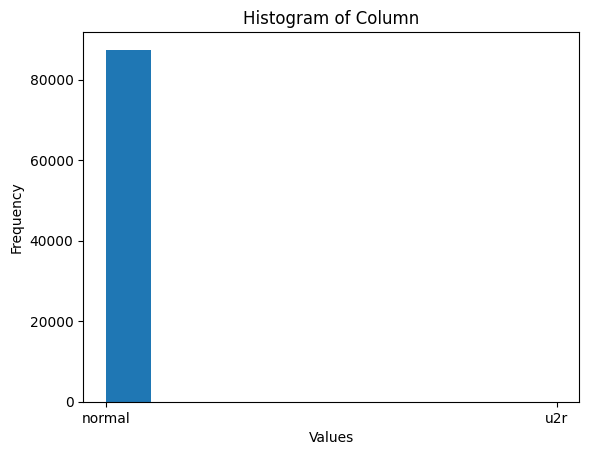

In [34]:
import matplotlib.pyplot as plt

df_train_f2 = copy.deepcopy(df_train_original)

for index, row in df_train_f2.iterrows():
    if row['attacks'] in ["dos", "probe"]:
        df_train_f2.at[index, 'attacks'] = 'normal'

plt.hist(df_train_f2['attacks'], bins=10)  # Adjust the number of bins as needed
plt.xlabel('Values')  # Set x-axis label
plt.ylabel('Frequency')  # Set y-axis label
plt.title('Histogram of Column')  # Set title
plt.savefig("x_train_f2.png")

print("Number of instances: ", df_train_f2['attacks'].value_counts())

plt.show()

Number of instances:  attacks
normal    37478
u2r          16
Name: count, dtype: int64


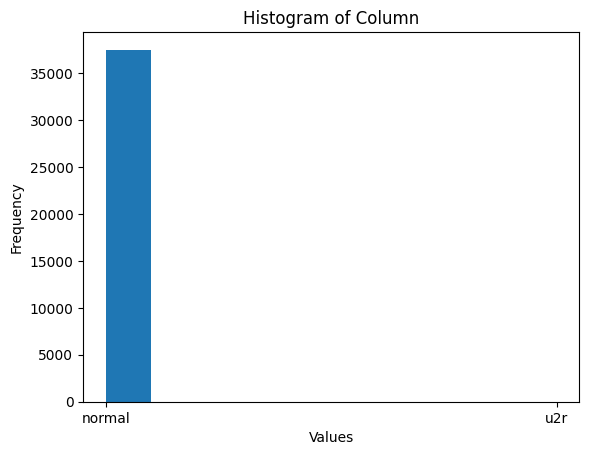

In [35]:
import matplotlib.pyplot as plt

df_val_f2 = copy.deepcopy(df_val_original)

for index, row in df_val_f2.iterrows():
    if row['attacks'] in ["dos", "probe"]:
        df_val_f2.at[index, 'attacks'] = 'normal'

# Assuming df is your DataFrame and 'column_name' is the specific column you want to plot
plt.hist(df_val_f2['attacks'], bins=10)  # Adjust the number of bins as needed
plt.xlabel('Values')  # Set x-axis label
plt.ylabel('Frequency')  # Set y-axis label
plt.title('Histogram of Column')  # Set title
plt.savefig("x_validate_f2.png")

print("Number of instances: ", df_val_f2['attacks'].value_counts())

plt.show()

In [36]:
df_train = copy.deepcopy(df_train_original)
df_test = copy.deepcopy(df_test_original)
df_val = copy.deepcopy(df_val_original)

# load targeted attacks (Normal + r2l + u2r)
df_train = df_train[df_train['label'].isin(normal_list+u2r_attacks+r2l_attacks)]
df_val = df_val[df_val['label'].isin(normal_list+u2r_attacks+r2l_attacks)]
df_test = df_test[df_test['label'].isin(normal_list+u2r_attacks+r2l_attacks)]

# set the target variables accordingly
y_train_l2 = np.array([1 if x in (u2r_attacks+r2l_attacks) else 0 for x in df_train['label']])
y_validate_l2 = np.array([1 if x in (u2r_attacks+r2l_attacks) else 0 for x in df_val['label']])
y_test = np.array([1 if x in (u2r_attacks+r2l_attacks) else 0 for x in df_test['label']])

df_train = df_train.drop(['label'],axis=1)
df_train = df_train.reset_index().drop(['index'], axis=1)
#df_train

In [37]:
df_val = df_val.drop(['label'],axis=1)
df_val = df_val.reset_index().drop(['index'], axis=1)
#df_val

In [38]:
df_test = df_test.drop(['label'],axis=1)
df_test = df_test.reset_index().drop(['index'], axis=1)
#df_test

In [39]:
X_train = df_train[common_features_l2]
X_validate = df_val[common_features_l2]
X_test = df_test[common_features_l2]

In [40]:
df_minmax = scaler2.fit_transform(X_train[common_features_l2])
X_train = pd.DataFrame(df_minmax, columns=X_train.columns)
#X_train

In [41]:
df_minmax = scaler2.transform(X_validate)
X_validate = pd.DataFrame(df_minmax, columns=X_validate.columns)
#X_validate

In [42]:
df_minmax = scaler2.transform(X_test)
X_test = pd.DataFrame(df_minmax, columns=X_test.columns)
#X_test

In [43]:
# perform One-hot encoding for the train set
label_enc = ohe2.fit_transform(df_train[categorical_features])
label_enc.toarray()
new_labels = ohe2.get_feature_names_out(categorical_features)
df_enc = pd.DataFrame(data=label_enc.toarray(), columns=new_labels)
X_train = pd.concat([X_train, df_enc], axis=1)
#X_train

In [44]:
# perform One-hot encoding for the validation set
label_enc = ohe2.transform(df_val[categorical_features])
label_enc.toarray()
new_labels = ohe2.get_feature_names_out(categorical_features)
df_enc = pd.DataFrame(data=label_enc.toarray(), columns=new_labels)
X_validate = pd.concat([X_validate, df_enc], axis=1)
#X_validate

In [45]:
# perform One-hot encoding for the test set
label_enc = ohe2.transform(df_test[categorical_features])
label_enc.toarray()
new_labels = ohe2.get_feature_names_out(categorical_features)
df_enc = pd.DataFrame(data=label_enc.toarray(), columns=new_labels)
X_test = pd.concat([X_test, df_enc], axis=1)
#X_test

Number of instances:  attacks
normal    87448
u2r          36
Name: count, dtype: int64


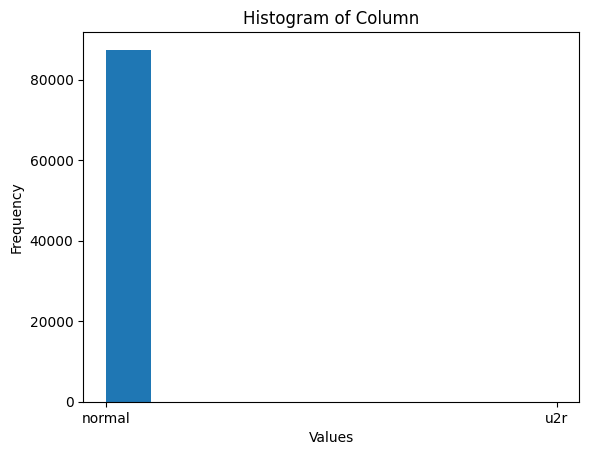

In [46]:
import matplotlib.pyplot as plt

df_train_f2 = copy.deepcopy(df_train_original)

for index, row in df_train_f2.iterrows():
    if row['attacks'] in ["dos", "probe"]:
        df_train_f2.at[index, 'attacks'] = 'normal'

# Assuming df is your DataFrame and 'column_name' is the specific column you want to plot
plt.hist(df_train_f2['attacks'], bins=10)  # Adjust the number of bins as needed
plt.xlabel('Values')  # Set x-axis label
plt.ylabel('Frequency')  # Set y-axis label
plt.title('Histogram of Column')  # Set title
plt.savefig("x_train_f3.png")

print("Number of instances: ", df_train_f2['attacks'].value_counts())

#plt.show()

In [47]:
# Under sampling the train set for l2
sm = under_sam(sampling_strategy=1)
X_train, y_train_l2 = sm.fit_resample(X_train,y_train_l2)

# Under sampling the validation set for l2
sm = under_sam(sampling_strategy=1)
X_validate, y_validate_l2 = sm.fit_resample(X_validate,y_validate_l2)

Number of instances:  attacks
normal    37478
u2r          16
Name: count, dtype: int64


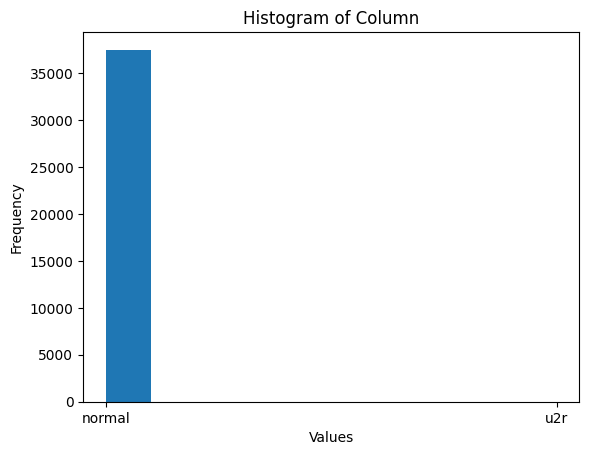

In [48]:
import matplotlib.pyplot as plt

df_val_f2 = copy.deepcopy(df_val_original)

for index, row in df_val_f2.iterrows():
    if row['attacks'] in ["dos", "probe"]:
        df_val_f2.at[index, 'attacks'] = 'normal'

# Assuming df is your DataFrame and 'column_name' is the specific column you want to plot
plt.hist(df_val_f2['attacks'], bins=10)  # Adjust the number of bins as needed
plt.xlabel('Values')  # Set x-axis label
plt.ylabel('Frequency')  # Set y-axis label
plt.title('Histogram of Column')  # Set title
plt.savefig("x_validate_f3.png")

print("Number of instances: ", df_val_f2['attacks'].value_counts())

#plt.show()

In [49]:
# Principal Component Analysis
pca_r2l_u2r = PCA(n_components=0.95)
X_train_r2l_u2r = pca_r2l_u2r.fit_transform(X_train)
X_test_r2l_u2r = pca_r2l_u2r.transform(X_test)
X_validate_r2l_u2r = pca_r2l_u2r.transform(X_validate)

In [50]:
# Support Vector Machine for layer l2
r2l_u2r_classifier = SVC(probability=True)

start = datetime.now()
r2l_u2r_classifier.fit(X_train_r2l_u2r, y_train_l2)
ttime = datetime.now() - start

from sklearn.svm import OneClassSVM

# One Class SVM for layer l2
r2l_u2r_classifier = OneClassSVM()

start = datetime.now()
r2l_u2r_classifier.fit(X_train_r2l_u2r)
ttime = datetime.now() - start

# Testing

In [51]:
df_test1 = copy.deepcopy(df_test_original)
df_test2 = copy.deepcopy(df_test_original)

y_test_real = np.array([0 if x=='normal' else 1 for x in df_test1['label']])

np.save("EvalResources/Test/KDDTest+_targets", y_test_real)

In [52]:
y_test_real.shape

(22544,)

In [53]:
X_test1 = df_test1[common_features_l1]

In [54]:
df_minmax = scaler1.transform(X_test1)
X_test1 = pd.DataFrame(df_minmax, columns=X_test1.columns)
label_enc = ohe.transform(df_test1.iloc[:,1:4])
label_enc.toarray()
new_labels = ohe.get_feature_names_out(categorical_features)
df_enc = pd.DataFrame(data=label_enc.toarray(), columns=new_labels)
X_test1 = pd.concat([X_test1, df_enc], axis=1)

X_test_layer1 = pca_dos_probe.transform(X_test1)
print('Test set shape for layer 1: ', X_test_layer1.shape)

Test set shape for layer 1:  (22544, 28)


In [55]:
#X_test1

In [56]:
X_test2 = df_test2

In [57]:
X_test2 = df_test2[common_features_l2] 

In [58]:
df_minmax = scaler2.transform(X_test2)
X_test2 = pd.DataFrame(df_minmax, columns=X_test2.columns)
label_enc = ohe2.transform(df_test2.iloc[:,1:4])
label_enc.toarray()
new_labels = ohe2.get_feature_names_out(categorical_features)
df_enc = pd.DataFrame(data=label_enc.toarray(), columns=new_labels)
X_test2 = pd.concat([X_test2, df_enc], axis=1)

X_test_layer2 = pca_r2l_u2r.transform(X_test2)
print('Test set shape for layer 1: ', X_test_layer1.shape)
print('Test set shape for layer 2: ', X_test_layer2.shape)

Test set shape for layer 1:  (22544, 28)
Test set shape for layer 2:  (22544, 12)


In [59]:
#X_test_layer1

In [60]:
#X_test_layer2

In [61]:
# same classifiers obtained above
classifier1 = dos_probe_classifier
classifier2 = r2l_u2r_classifier

In [62]:
import warnings

# Suppressing the warning
warnings.filterwarnings("ignore", message="X does not have valid feature names.*")

import numpy as np
from datetime import datetime

def test_metrics():
    result_ = []
    tn, fp, fn, tp = 0, 0, 0, 0
    
    start_ = datetime.now()
    
    for i in range(X_test_layer2.shape[0]):
        layer1_ = classifier1.predict(X_test_layer1[i].reshape(1, -1))[0]
        if layer1_ == 1:
            result_.append(layer1_)
        else:
            layer2_ = classifier2.predict(X_test_layer2[i].reshape(1, -1))[0]
            if layer2_ == 1:
                result_.append(layer2_)
            else:
                result_.append(0)
        # Evaluate confusion matrix
        if y_test_real[i] == 1:
            if result_[-1] == 1:
                tp += 1
            else:
                fn += 1
        else:
            if result_[-1] == 1:
                fp += 1
            else:
                tn += 1
    
    clf_time_ = datetime.now() - start_
    
    # Calculate rates
    tnr_ = tn / (tn + fp)
    fpr_= fp / (fp + tn)
    fnr_ = fn / (fn + tp)
    
    return (accuracy_score(y_test_real,np.array(result_)), 
            f1_score(y_test_real, np.array(result_)),
            precision_score(y_test_real, np.array(result_)),
            recall_score(y_test_real, np.array(result_)),
            clf_time_, tnr_, fpr_, fnr_, np.array(result_))

In [63]:
# the results may vary
accuracy, f_score, precision, recall, clf_time, tnr, fpr, fnr, result = test_metrics()

In [64]:
# load testset
df_test = pd.read_csv('EvalResources/KDDTest+.txt', sep=",", header=None, skipinitialspace=True)
df_test = df_test[df_test.columns[:-1]]
df_test.columns = titles.to_list()
y_test = df_test['label']
df_test = df_test.drop(['num_outbound_cmds'], axis=1)

df_test_original = df_test
if EXPORT_DATASETS:
    df_test_original.to_csv('EvalResources/ProcessedDatasets/x_test_full.txt', index=False)
    np.save('EvalResources/ProcessedDatasets/y_test_full', y_test)

#df_test_original
new_attack = []
for i in df_test_original['label'].value_counts().index.tolist()[1:]:
    if i not in df_train_original['label'].value_counts().index.tolist()[1:]:
        new_attack.append(i)

new_attack.sort()
#new_attack
index_of_new_attacks = []

for i in range(len(df_test_original)):
    if df_test_original['label'][i] in new_attack:
        index_of_new_attacks.append(df_test_original.index[i])

new_attack.append('normal')

index_of_old_attacks = []

for i in range(len(df_test_original)):
    if df_test_original['label'][i] not in new_attack:
        index_of_old_attacks.append(df_test_original.index[i])

In [65]:
### Evaluate single attack types
# load test set
df_test = pd.read_csv('EvalResources/KDDTest+.txt', sep=",", header=None, skipinitialspace=True)
df_test = df_test[df_test.columns[:-1]]
df_test.columns = titles.to_list()
y_test = df_test['label']
df_test = df_test.drop(['num_outbound_cmds'], axis=1)
df_test_original = df_test
df = df_test_original

dos_index = df.index[(df['label'].isin(dos_attacks))].tolist()
probe_index = df.index[(df['label'].isin(probe_attacks))].tolist()
r2l_index = df.index[(df['label'].isin(r2l_attacks))].tolist()
u2r_index = df.index[(df['label'].isin(u2r_attacks))].tolist()

"""
print('Accuracy = ', accuracy)
print('F1 Score = ', f_score)
print('Precision = ', precision)
print('Recall = ', recall)
print('Classification time = ', clf_time)

print('True Negative Rate (TNR) =', tnr)
print('False Positive Rate (FPR) =', fpr)
print('False Negative Rate (FNR) =', fnr)

print("Ratio of DOS detection: ", result[dos_index].sum() / result[dos_index].shape[0])

print("Ratio of PROBE detection: ", result[probe_index].sum() / result[probe_index].shape[0])

print("Ratio of U2R detection: ", result[r2l_index].sum() / result[r2l_index].shape[0])

print("Ratio of R2L detection: ", result[u2r_index].sum() / result[u2r_index].shape[0])

print('New attacks detected: ',
      result[index_of_new_attacks].sum() / result[index_of_new_attacks].shape[0])

print('Old attacks detected: ',
      result[index_of_old_attacks].sum() / result[index_of_old_attacks].shape[0])
"""

print('{:.3f}'.format(accuracy))
print('{:.3f}'.format(f_score))
print('{:.3f}'.format(precision))
print('{:.3f}'.format(recall))
print(clf_time)

print('{:.3f}'.format(tnr))
print('{:.3f}'.format(fpr))
print('{:.3f}'.format(fnr))

print('{:.3f}'.format(result[dos_index].sum() / result[dos_index].shape[0]))

print('{:.3f}'.format(result[probe_index].sum() / result[probe_index].shape[0]))

print('{:.3f}'.format(result[r2l_index].sum() / result[r2l_index].shape[0]))

print('{:.3f}'.format(result[u2r_index].sum() / result[u2r_index].shape[0]))

print('{:.3f}'.format(result[index_of_new_attacks].sum() / result[index_of_new_attacks].shape[0]))

print('{:.3f}'.format(result[index_of_old_attacks].sum() / result[index_of_old_attacks].shape[0]))


0.869
0.881
0.913
0.852
0:00:28.189482
0.892
0.108
0.148
0.912
0.949
0.613
0.896
0.754
0.937


# Now start the adaptation process

In [66]:
from sklearn.metrics import precision_score
import optuna
from optuna.samplers import CmaEsSampler

In [67]:
p1, p2, p3, p4 = 0, 0, 0, 1
f1, f2, f3 = 0, 0, 0

from sklearn.ensemble import VotingClassifier, HistGradientBoostingClassifier

hgb_params = {
    'learning_rate': optuna.distributions.FloatDistribution(0.001, 0.1),
    'max_iter': optuna.distributions.IntDistribution(50, 500),
    'max_depth': optuna.distributions.IntDistribution(2, 32),
    'min_samples_leaf': optuna.distributions.IntDistribution(1, 10)
}

rf_params = {
    'n_estimators': optuna.distributions.IntDistribution(50, 500),
    'max_depth': optuna.distributions.IntDistribution(2, 32),
    'min_samples_split': optuna.distributions.IntDistribution(2, 20),
    'min_samples_leaf': optuna.distributions.IntDistribution(1, 10)
}

svm_params = {
    'C': optuna.distributions.FloatDistribution(0.1, 10),
    'kernel': optuna.distributions.CategoricalDistribution(['linear', 'poly', 'rbf', 'sigmoid']),
    'gamma': optuna.distributions.FloatDistribution(1e-6, 1e-2)
}

nbc_params = {
    'var_smoothing': optuna.distributions.FloatDistribution(1e-10, 1e-1)
}

def objective(trial):
    
    alpha = trial.suggest_float('alpha', 0.0, 1.0)
    beta = trial.suggest_float('beta', 0.0, 1.0)
    
    gnb_hyperparams = {
        'var_smoothing': trial.suggest_float('gnb_var_smoothing', 1e-10, 1e-1, log=True)
    }
    
    rf_hyperparams = {
        'n_estimators': trial.suggest_int('rf_n_estimators', 10, 70),
        'max_depth': trial.suggest_int('rf_max_depth', 2, 32),
        'min_samples_split': trial.suggest_int('rf_min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('rf_min_samples_leaf', 1, 10)
    }
    
    hgb_hyperparams = {
        'learning_rate': trial.suggest_float('hgb_learning_rate', 0.001, 0.1, log=True),
        'max_iter': trial.suggest_int('hgb_max_iter', 50, 500),
        'max_depth': trial.suggest_int('hgb_max_depth', 2, 32),
        'min_samples_leaf': trial.suggest_int('hgb_min_samples_leaf', 1, 10)
    }
    
    svm_hyperparams = {
        'C': trial.suggest_float('svm_C', 0.1, 10),
        'kernel': trial.suggest_categorical('svm_kernel', ['linear', 'poly', 'rbf', 'sigmoid']),
        'gamma': trial.suggest_float('svm_gamma', 1e-6, 1e-2)
    }
    
    if p1:
        clf1 = HistGradientBoostingClassifier(**hgb_hyperparams)
        clf1.fit(X_train_dos_probe, y_train_l1)
    if p2:
        clf1 = RandomForestClassifier(**rf_hyperparams)
        clf1.fit(X_train_dos_probe, y_train_l1)
    if p3:
        v1 = RandomForestClassifier(**rf_hyperparams)        
        v2 = GaussianNB(**gnb_hyperparams)
        
        clf1 = VotingClassifier([("rf", v1), ("gnb", v2)])
        clf1.fit(X_train_dos_probe, y_train_l1)
    if p4:
        v1 = HistGradientBoostingClassifier(**hgb_hyperparams)        
        v2 = GaussianNB(**gnb_hyperparams)
        
        clf1 = VotingClassifier([("rf", v1), ("gnb", v2)])
        clf1.fit(X_train_dos_probe, y_train_l1)
        
    clf2 = SVC(**svm_hyperparams)
    clf2.fit(X_train_r2l_u2r, y_train_l2)
    
    # Predict on validation set and calculate metrics for both classifiers
    l1_predicted = clf1.predict(X_validate_dos_probe)
    l2_predicted = clf2.predict(X_validate_r2l_u2r)
    
    # Calculate recall scores for both classifiers
    recall_l1 = recall_score(y_validate_l1, l1_predicted)
    recall_l2 = recall_score(y_validate_l2, l2_predicted)
    
    # Calculate the average recall
    avg_recall = (recall_l1 + recall_l2) / 2
    
    # Calculate false negative rates (FNR) for both classifiers
    fnr_l1 = 1 - recall_l1
    fnr_l2 = 1 - recall_l2
    
    # Calculate the average FNR
    avg_fnr = (fnr_l1 + fnr_l2) / 2
    
    penalty = max(0, avg_recall - 0.8)  # Penalize if TPR exceeds 0.8
    
    # return values according to the scenario
    if (p4 and f2) or (f3 and p3):
        return avg_fnr
    else:
        return 0.5 * avg_recall - beta * avg_fnr - penalty
    

# Create Optuna study and optimize
study = optuna.create_study(direction='maximize')

start = datetime.now()
study.optimize(objective, n_trials=20, n_jobs=-1)
tuning_time = datetime.now() - start

S2: (HGBC+NBC) + SVM

In [116]:
hgb_params = {
    'learning_rate': optuna.distributions.FloatDistribution(0.001, 0.1),
    'max_iter': optuna.distributions.IntDistribution(50, 500),
    'max_depth': optuna.distributions.IntDistribution(2, 32),
    'min_samples_leaf': optuna.distributions.IntDistribution(1, 10)
}

svm_params = {
    'C': optuna.distributions.FloatDistribution(0.1, 10),
    'kernel': optuna.distributions.CategoricalDistribution(['linear', 'poly', 'rbf', 'sigmoid']),
    'gamma': optuna.distributions.FloatDistribution(1e-6, 1e-2)
}

def objective(trial):
    # Define hyperparameters for HistGradientBoostingClassifier
    hgb_hyperparams = {
        'learning_rate': trial.suggest_float('hgb_learning_rate', 0.001, 0.1, log=True),
        'max_iter': trial.suggest_int('hgb_max_iter', 50, 500),
        'max_depth': trial.suggest_int('hgb_max_depth', 2, 32),
        'min_samples_leaf': trial.suggest_int('hgb_min_samples_leaf', 1, 10)
    }
    
    
    # Define hyperparameters for SVM
    svm_hyperparams = {
        'C': trial.suggest_float('svm_C', 0.1, 10),
        'kernel': trial.suggest_categorical('svm_kernel', ['linear', 'poly', 'rbf', 'sigmoid']),
        'gamma': trial.suggest_float('svm_gamma', 1e-6, 1e-2)
    }
    """
    
    # Define hyperparameters for SVM
    svm_hyperparams = {
        'C': trial.suggest_float('svm_C', 0.1, 0.1),
        'kernel': trial.suggest_categorical('svm_kernel', ['rbf']),
        'gamma': trial.suggest_float('svm_gamma', 0.01, 0.01)
    }
    """
    
    # Define hyperparameters for GaussianNB
    gnb_hyperparams = {
        'var_smoothing': trial.suggest_float('gnb_var_smoothing', 1e-10, 1e-1, log=True)
    }
    
    # Initialize the rf
    hgb_classifier = HistGradientBoostingClassifier(**hgb_hyperparams)
    
    # Initialize the nbc
    nbc_classifier = GaussianNB(**gnb_hyperparams)
    
    # Initialize and train voting classifier
    voting_classifier = VotingClassifier(
        estimators=[("hgbc", hgb_classifier), ("nbc", nbc_classifier)] ,
        voting='soft'
    )
    voting_classifier.fit(X_train_dos_probe, y_train_l1)
    
    # Initialize and train SVM classifier
    svm_classifier = SVC(**svm_hyperparams)
    svm_classifier.fit(X_train_r2l_u2r, y_train_l2)
    
    # Predict on validation set and calculate metrics for both classifiers
    voting_predicted = voting_classifier.predict(X_validate_dos_probe)
    svm_predicted = svm_classifier.predict(X_validate_r2l_u2r)
    
    # Calculate confusion matrices for both classifiers
    voting_cm = confusion_matrix(y_validate_l1, voting_predicted)
    svm_cm = confusion_matrix(y_validate_l2, svm_predicted)
    
    # Calculate False Negative Rates for both classifiers
    voting_fnr = voting_cm[1, 0] / np.sum(voting_cm[1, :])
    svm_fnr = svm_cm[1, 0] / np.sum(svm_cm[1, :])
    
    # Calculate the average FNR
    avg_fnr = (voting_fnr + svm_fnr) / 2
    
    return avg_fnr


# Create Optuna study and optimize
study = optuna.create_study(direction='minimize')

start = datetime.now()
study.optimize(objective, n_trials=100, n_jobs=-1)
tuning_time = datetime.now() - start

[I 2024-03-11 17:31:07,107] A new study created in memory with name: no-name-aa345831-e290-453d-95c5-7c955db93082
[I 2024-03-11 17:31:21,377] Trial 12 finished with value: 0.06838075114324363 and parameters: {'hgb_learning_rate': 0.06858058330994442, 'hgb_max_iter': 77, 'hgb_max_depth': 25, 'hgb_min_samples_leaf': 8, 'svm_C': 2.322437014751851, 'svm_kernel': 'sigmoid', 'svm_gamma': 3.544852360172682e-05, 'gnb_var_smoothing': 5.304572832320954e-10}. Best is trial 12 with value: 0.06838075114324363.
[I 2024-03-11 17:31:24,388] Trial 8 finished with value: 0.10208462105572844 and parameters: {'hgb_learning_rate': 0.01901297589639982, 'hgb_max_iter': 98, 'hgb_max_depth': 26, 'hgb_min_samples_leaf': 7, 'svm_C': 2.2008514614685852, 'svm_kernel': 'linear', 'svm_gamma': 0.0031750662990458456, 'gnb_var_smoothing': 4.2877633086004764e-07}. Best is trial 12 with value: 0.06838075114324363.
[I 2024-03-11 17:31:27,509] Trial 3 finished with value: 0.10549989665824666 and parameters: {'hgb_learning_

S2: (RF+NBC) + SVM

S4: (HGBC+NBC) + SVM

from sklearn.ensemble import HistGradientBoostingClassifier

hgb_params = {
    'learning_rate': optuna.distributions.FloatDistribution(0.001, 0.1),
    'max_iter': optuna.distributions.IntDistribution(50, 500),
    'max_depth': optuna.distributions.IntDistribution(2, 32),
    'min_samples_leaf': optuna.distributions.IntDistribution(1, 10)
}

svm_params = {
    'C': optuna.distributions.FloatDistribution(0.1, 10),
    'kernel': optuna.distributions.CategoricalDistribution(['linear', 'poly', 'rbf', 'sigmoid']),
    'gamma': optuna.distributions.FloatDistribution(1e-6, 1e-2)
}

nbc_params = {
    'var_smoothing': optuna.distributions.FloatDistribution(1e-10, 1e-1)
}

def objective(trial):
    # Define hyperparameters for Random Forest
    hgb_hyperparams = {
        'learning_rate': trial.suggest_float('hgb_learning_rate', 0.001, 0.1, log=True),
        'max_iter': trial.suggest_int('hgb_max_iter', 50, 500),
        'max_depth': trial.suggest_int('hgb_max_depth', 2, 32),
        'min_samples_leaf': trial.suggest_int('hgb_min_samples_leaf', 1, 10)
    }
    
    # Define hyperparameters for GaussianNB
    gnb_hyperparams = {
        'var_smoothing': trial.suggest_float('gnb_var_smoothing', 1e-10, 1e-1, log=True)
    }
    
    
    # Define hyperparameters for SVM
    svm_hyperparams = {
        'C': trial.suggest_float('svm_C', 0.1, 10),
        'kernel': trial.suggest_categorical('svm_kernel', ['linear', 'poly', 'rbf', 'sigmoid']),
        'gamma': trial.suggest_float('svm_gamma', 1e-6, 1e-2)
    }
    """
    
    # Define hyperparameters for SVM
    svm_hyperparams = {
        'C': trial.suggest_float('svm_C', 0.1, 0.1),
        'kernel': trial.suggest_categorical('svm_kernel', ['rbf']),
        'gamma': trial.suggest_float('svm_gamma', 0.01, 0.01)
    }
    """
    
    voting_classifier = VotingClassifier(
        [("hgbc", HistGradientBoostingClassifier(**hgb_hyperparams)), ("nbc", GaussianNB(**gnb_hyperparams))],
        voting='soft'
    )
    voting_classifier.fit(X_train_dos_probe, y_train_l1)
    
    hgb_classifier = HistGradientBoostingClassifier(**hgb_hyperparams)
    hgb_classifier.fit(X_train_dos_probe, y_train_l1)
    
    # Initialize and train SVM classifier
    svm_classifier = SVC(**svm_hyperparams)
    svm_classifier.fit(X_train_r2l_u2r, y_train_l2)
    
    # Predict on validation set and calculate metrics for both classifiers
    hgb_predicted = hgb_classifier.predict(X_validate_dos_probe)
    svm_predicted = svm_classifier.predict(X_validate_r2l_u2r)
    
    # Calculate confusion matrices for both classifiers
    hgb_cm = confusion_matrix(y_validate_l1, hgb_predicted)
    svm_cm = confusion_matrix(y_validate_l2, svm_predicted)
    
    # Calculate Precision and False Negative Rate (FNR) for both classifiers
    hgb_precision = hgb_cm[1, 1] / np.sum(hgb_cm[:, 1])
    hgb_fnr = hgb_cm[1, 0] / np.sum(hgb_cm[1, :])
    
    svm_precision = svm_cm[1, 1] / np.sum(svm_cm[:, 1])
    svm_fnr = svm_cm[1, 0] / np.sum(svm_cm[1, :])
    
    # Calculate the average Precision and FNR
    avg_precision = (hgb_precision + svm_precision) / 2
    avg_fnr = (hgb_fnr + svm_fnr) / 2
    
    # Aim to optimize both Precision and FNR
    return 1 - (avg_precision + avg_fnr)  # Minimize the sum of Precision and FNR


# Create Optuna study and optimize
study = optuna.create_study(direction='minimize')

start = datetime.now()
study.optimize(objective, n_trials=100, n_jobs=-1)
tuning_time = datetime.now() - start

S4: (RF+NBC) + SVM

import optuna

rf_params = {
    'n_estimators': optuna.distributions.IntDistribution(50, 500),
    'max_depth': optuna.distributions.IntDistribution(2, 32),
    'min_samples_split': optuna.distributions.IntDistribution(2, 20),
    'min_samples_leaf': optuna.distributions.IntDistribution(1, 10)
}

svm_params = {
    'C': optuna.distributions.FloatDistribution(0.1, 10),
    'kernel': optuna.distributions.CategoricalDistribution(['linear', 'poly', 'rbf', 'sigmoid']),
    'gamma': optuna.distributions.FloatDistribution(1e-6, 1e-2)
}

nbc_params = {
    'var_smoothing': optuna.distributions.FloatDistribution(1e-10, 1e-1)
}

def objective(trial):
    # Define hyperparameters for Random Forest
    rf_hyperparams = {
        'n_estimators': trial.suggest_int('rf_n_estimators', 10, 70),
        'max_depth': trial.suggest_int('rf_max_depth', 2, 32),
        'min_samples_split': trial.suggest_int('rf_min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('rf_min_samples_leaf', 1, 10)
    }
    
    # Define hyperparameters for GaussianNB
    gnb_hyperparams = {
        'var_smoothing': trial.suggest_float('gnb_var_smoothing', 1e-10, 1e-1, log=True)
    }
    
    
    # Define hyperparameters for SVM
    svm_hyperparams = {
        'C': trial.suggest_float('svm_C', 0.1, 10),
        'kernel': trial.suggest_categorical('svm_kernel', ['linear', 'poly', 'rbf', 'sigmoid']),
        'gamma': trial.suggest_float('svm_gamma', 1e-6, 1e-2)
    }
    """
    
    # Define hyperparameters for SVM
    svm_hyperparams = {
        'C': trial.suggest_float('svm_C', 0.1, 0.1),
        'kernel': trial.suggest_categorical('svm_kernel', ['rbf']),
        'gamma': trial.suggest_float('svm_gamma', 0.01, 0.01)
    }
    """
    
    voting_classifier = VotingClassifier(
        [("rf", RandomForestClassifier(**rf_hyperparams)), ("nbc", GaussianNB(**gnb_hyperparams))],
        voting='soft'
    )
    voting_classifier.fit(X_train_dos_probe, y_train_l1)
    
    # Initialize and train SVM classifier
    svm_classifier = SVC(**svm_hyperparams)
    svm_classifier.fit(X_train_r2l_u2r, y_train_l2)
    
    # Predict on validation set and calculate metrics for both classifiers
    voting_predicted = voting_classifier.predict(X_validate_dos_probe)
    svm_predicted = svm_classifier.predict(X_validate_r2l_u2r)
    
    # Calculate confusion matrices for both classifiers
    voting_cm = confusion_matrix(y_validate_l1, voting_predicted)
    svm_cm = confusion_matrix(y_validate_l2, svm_predicted)
    
    # Calculate Precision and False Negative Rate (FNR) for both classifiers
    voting_precision = voting_cm[1, 1] / np.sum(voting_cm[:, 1])
    voting_fnr = voting_cm[1, 0] / np.sum(voting_cm[1, :])
    
    svm_precision = svm_cm[1, 1] / np.sum(svm_cm[:, 1])
    svm_fnr = svm_cm[1, 0] / np.sum(svm_cm[1, :])
    
    # Calculate the average Precision and FNR
    avg_precision = (voting_precision + svm_precision) / 2
    avg_fnr = (voting_fnr + svm_fnr) / 2
    
    # Aim to optimize both Precision and FNR
    return 1 - (avg_precision + avg_fnr)  # Minimize the sum of Precision and FNR


# Create Optuna study and optimize
study = optuna.create_study(direction='minimize')

start = datetime.now()
study.optimize(objective, n_trials=100, n_jobs=-1)
tuning_time = datetime.now() - start

# Get the best hyperparameters

In [117]:
from sklearn.ensemble import HistGradientBoostingClassifier

best_params_nbc = {
    'var_smoothing': study.best_trial.params['gnb_var_smoothing']
}

best_params2 = {
    'C': study.best_trial.params['svm_C'],
    'kernel': study.best_trial.params['svm_kernel'],
    'gamma': study.best_trial.params['svm_gamma']
}

best_classifier2 = SVC(**best_params2)
best_classifier2.fit(X_train_r2l_u2r, y_train_l2)

if p1:
    best_params1 = {
        'learning_rate': study.best_trial.params['hgb_learning_rate'],
        'max_depth': study.best_trial.params['hgb_max_depth'],
        'max_iter': study.best_trial.params['hgb_max_iter'],
        'min_samples_leaf': study.best_trial.params['hgb_min_samples_leaf']
    }
    
    best_classifier1 = HistGradientBoostingClassifier(**best_params1)
    best_classifier1.fit(X_train_dos_probe, y_train_l1)
    
if p2:
    best_params1 = {
        'n_estimators': study.best_trial.params['rf_n_estimators'],
        'max_depth': study.best_trial.params['rf_max_depth'],
        'min_samples_split': study.best_trial.params['rf_min_samples_split'],
        'min_samples_leaf': study.best_trial.params['rf_min_samples_leaf']
    }
    
    best_classifier1 = RandomForestClassifier(**best_params1)
    best_classifier1.fit(X_train_dos_probe, y_train_l1)
    
if p3:
    best_params1 = {
        'n_estimators': study.best_trial.params['rf_n_estimators'],
        'max_depth': study.best_trial.params['rf_max_depth'],
        'min_samples_split': study.best_trial.params['rf_min_samples_split'],
        'min_samples_leaf': study.best_trial.params['rf_min_samples_leaf']
    }
    
    best_classifier1 = VotingClassifier(
        [("rf", RandomForestClassifier(**best_params1)), ("nbc", GaussianNB(**best_params_nbc))],
        voting='soft')
    best_classifier1.fit(X_train_dos_probe, y_train_l1)
    
if p4:
    best_params1 = {
        'learning_rate': study.best_trial.params['hgb_learning_rate'],
        'max_depth': study.best_trial.params['hgb_max_depth'],
        'max_iter': study.best_trial.params['hgb_max_iter'],
        'min_samples_leaf': study.best_trial.params['hgb_min_samples_leaf']
    }
    
    best_classifier1 = VotingClassifier(
        [("hgbc", HistGradientBoostingClassifier(**best_params1)), ("nbc", GaussianNB(**best_params_nbc))],
        voting='soft')
    best_classifier1.fit(X_train_dos_probe, y_train_l1)

In [118]:
classifier1 = best_classifier1
classifier2 = best_classifier2

In [119]:
# the results may vary
accuracy, f_score, precision, recall, clf_time, tnr, fpr, fnr, result = test_metrics()

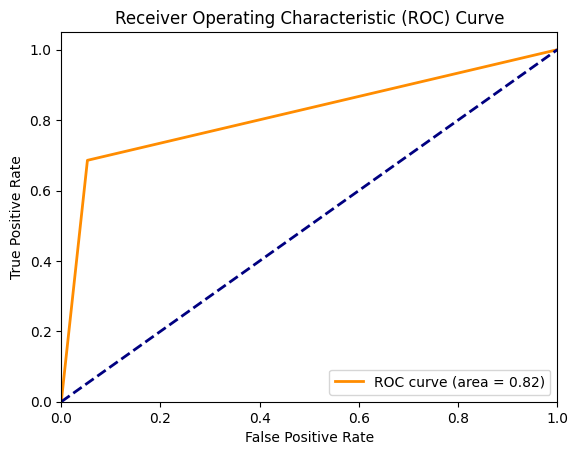

In [120]:
# ROC graph

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_test_real, result)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

if p2:
    if f1:
        plt.savefig('static_roc_curve-rf-f1.png')
    if f2:
        plt.savefig('static_roc_curve-rf-f2.png')
    if f3:
        plt.savefig('static_roc_curve-rf-f3.png')
        
if p1:
    if f1:
        plt.savefig('static_roc_curve-hgbc-f1.png')
    if f2:
        plt.savefig('static_roc_curve-hgbc-f2.png')
    if f3:
        plt.savefig('static_roc_curve-hgbc-f3.png')
        
if p3:
    if f1:
        plt.savefig('static_roc_curve-voting-rf-f1.png')
    if f2:
        plt.savefig('static_roc_curve-voting-rf-f2.png')
    if f3:
        plt.savefig('static_roc_curve-voting-rf-f3.png')
        
if p3:
    if f1:
        plt.savefig('static_roc_curve-voting-hgbc-f1.png')
    if f2:
        plt.savefig('static_roc_curve-voting-hgbc-f2.png')
    if f3:
        plt.savefig('static_roc_curve-voting-hgbc-f3.png')


plt.savefig('S3_HGBC+NBC.png')

plt.show()

### evaluate seen and unseen attack categories

In [121]:
# load testset
df_test = pd.read_csv('EvalResources/KDDTest+.txt', sep=",", header=None, skipinitialspace = True)
df_test = df_test[df_test.columns[:-1]]
df_test.columns = titles.to_list()
y_test = df_test['label']
df_test = df_test.drop(['num_outbound_cmds'],axis=1)

df_test_original = df_test

In [122]:
new_attack = []
for i in df_test_original['label'].value_counts().index.tolist()[1:]:
    if i not in df_train_original['label'].value_counts().index.tolist()[1:]:
        new_attack.append(i)
        
new_attack.sort()
#new_attack

In [123]:
index_of_new_attacks = []

for i in range(len(df_test_original)):
    if df_test_original['label'][i] in new_attack:
        index_of_new_attacks.append(df_test_original.index[i])

In [124]:
#len(index_of_new_attacks)

In [125]:
new_attack.append('normal')
#new_attack

In [126]:
index_of_old_attacks = []

for i in range(len(df_test_original)):
    if df_test_original['label'][i] not in new_attack:
        index_of_old_attacks.append(df_test_original.index[i])

### Evaluate single attack types

In [127]:
# load test set
df_test = pd.read_csv('EvalResources/KDDTest+.txt', sep=",", header=None, skipinitialspace = True)
df_test = df_test[df_test.columns[:-1]]
df_test.columns = titles.to_list()
y_test = df_test['label']
df_test = df_test.drop(['num_outbound_cmds'],axis=1)
df_test_original = df_test
df = df_test_original

dos_index = df.index[(df['label'].isin(dos_attacks))].tolist()
probe_index = df.index[(df['label'].isin(probe_attacks))].tolist()
r2l_index = df.index[(df['label'].isin(r2l_attacks))].tolist()
u2r_index = df.index[(df['label'].isin(u2r_attacks))].tolist()

print('Accuracy = ', accuracy)
print('F1 Score = ', f_score)
print('Precision = ', precision)
print('Recall = ', recall)

print('tuning_time: ', tuning_time)
print('True Negative Rate (TNR) =', tnr)
print('False Positive Rate (FPR) =', fpr)

print('False Negative Rate (FNR) =', fnr)

print("Ratio DOS of detection: ", result[dos_index].sum()/result[dos_index].shape[0])

print("Ratio PROBE of detection: ", result[probe_index].sum()/result[probe_index].shape[0])

print("Ratio U2R of detection: ", result[r2l_index].sum()/result[r2l_index].shape[0])

print("Ratio R2L of detection: ", result[u2r_index].sum()/result[u2r_index].shape[0])

print('New attacks detected: ', result[index_of_new_attacks].sum()/result[index_of_new_attacks].shape[0])

print('Old attacks detected: ', result[index_of_old_attacks].sum()/result[index_of_old_attacks].shape[0])

Accuracy =  0.7984386089425124
F1 Score =  0.7948162196333423
Precision =  0.9450230860088049
Recall =  0.6858100210395075
tuning_time:  0:05:30.317736
True Negative Rate (TNR) = 0.9472762846256823
False Positive Rate (FPR) = [0.         0.05272372 1.        ]
False Negative Rate (FNR) = 0.3141899789604925
Ratio DOS of detection:  0.7689008042895442
Ratio PROBE of detection:  0.9264766625361421
Ratio U2R of detection:  0.2662045060658579
Ratio R2L of detection:  0.8059701492537313
New attacks detected:  0.39872247436543956
Old attacks detected:  0.93390470656595
